# Import Library 

In [652]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [802]:
path='./data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)


# 1. users

## 1) Exploratory Data Analysis

In [3]:
users.head() # 상위 5개 행 출력

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [4]:
users.info() # 각 컬럼별 특징

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
users.shape

(68092, 3)

In [6]:
users.isnull().sum()

user_id         0
location        0
age         27833
dtype: int64

In [7]:
users.isna().sum()/len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

In [8]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [9]:
users['user_id'].nunique()

68092

# 2) Preprocessing & Feature Engineering

### 2-1) location

In [10]:
users['location'][:5]

0              timmins, ontario, canada
1               ottawa, ontario, canada
2                         n/a, n/a, n/a
3              toronto, ontario, canada
4    victoria, british columbia, canada
Name: location, dtype: object

location의 경우 -> 지역, 주, 국가 순서로 값이 이루어져 있음. n/a와 같은 형식의 결측치가 보인다.

In [752]:
users[users['location'].str.contains('n/a')]

,user_id,location,age
2,11676,"n/a, n/a, n/a",NaN
633,271622,"malmok, n/a, aruba",NaN
720,8674,"singapore, n/a, singapore",29.0
732,10570,"singapore, n/a, singapore",NaN
748,12331,"athens, n/a, greece",31.0
...,...,...,...
68052,275874,"zürich, n/a, switzerland",NaN
68061,276618,"stuttgart, \n/a\""., germany""",NaN
68063,276660,"singapore, n/a, singapore",15.0
68064,276729,"rijeka, n/a, croatia",16.0


location의 지역, 주, 국가가 모두 비어있는 경우와 주만 비어있는 경우 등 다양한 경우가 존재하는 것으로 보임\
-> 지역, 주, 국가로 컬럼을 나누어 확인해봐야함

In [12]:
# 🔥 기존에 샘플코드로 제공해준 아래코드로는 변환 제대로 안됨 -> re모듈 사용하거나 for문으로 바꿔줘야됨(replace는 정규식 패턴에 대응하는 문자열을 찾아주지는 못한다. 그래서 re.sub 메서드가 필요)
# users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거(숫자, 알파벳, 콜론(:), 쉼표(,)를 제외한 모든 특수문자를 빈 문자열('')로 대체)

In [803]:
users['location'] = users['location'].apply(lambda x: re.sub(r'[^a-zA-Z:,]', '', x)) # 특수문자 제거(숫자도 포함해서 제거해줌)

In [804]:
print(users['location'][2]) # 'n/a, n/a, n/a'
print(users['location'][68061]) # 'stuttgart, \n/a\"., germany"'

na,na,na
stuttgart,na,germany


In [805]:
# baseline에서는 아래코드로만 결측치를 다 채움
users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip()) # city
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip()) # state
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip()) # country

In [806]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city           0
location_state          0
location_country        0
dtype: int64

하지만 제대로 결측치에 대한 처리가 이루어지지 않았음

In [807]:
# 샘플로 주어진 아래 코드로는 location의 값이 np.nan값으로 제대로 바뀌지 않음. city, state, country의 값만 바뀌게됨(이게 됐으면 canada의 na도 바꼈을거임)
users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다. (이 코드로 location의 공백이 들어있는 값이 np.nan으로 바뀌지 않음)

# na가 여러개 포함돼있는 location값 전처리할 필요가 없음. 필요하면 city, state, country 보면 됨 -> city, state, country 값만 np.nan으로 바꿔주자.

In [808]:
users['location'] = users['location'].apply(lambda x: ','.join(map(str, ['na' if '' == i else i for i in x.split(',')])))

In [19]:
# users['location'] = users['location'].apply(lambda x: x.replace('na', ' ') if 'na,' in x or ',na' in x else x) # 혹시 몰라 만들어놓은 na -> 공백으로 바꾸는 코드

In [20]:
print(users[['location_city', 'location_state', 'location_country']].iloc[2].values) # 'nan, nan, nan'
print(users[['location_city', 'location_state', 'location_country']].iloc[68061].values) # 'stuttgart,nan,germany'

[nan nan nan]
['stuttgart' nan 'germany']


In [809]:
users.isnull().sum() # 다시 확인해본 결측치

user_id                 0
location                0
age                 27833
location_city         129
location_state       3254
location_country     2124
dtype: int64

**결측치가 많은 순: state(주) > country(국가) > city(지역)**

~~state, country, city의 정보를 꼭 모두 사용해야할까? 🔥~~

샘플 코드에서는 city, state, country에 대한 별도의 처리를 해주지 않는다. 

In [22]:
users[users['location_state'].isna()] # 결측치가 가장 많은 location_state 확인

,user_id,location,age,location_city,location_state,location_country
2,11676,"na,na,na",NaN,NaN,NaN,NaN
6,116866,"ottawa,na,na",NaN,ottawa,NaN,NaN
32,115097,"seattle,na,na",27.0,seattle,NaN,NaN
49,245827,"albuquerque,na,na",NaN,albuquerque,NaN,NaN
72,226745,"humble,na,na",38.0,humble,NaN,NaN
...,...,...,...,...,...,...
68058,276221,"calgary,na,na",NaN,calgary,NaN,NaN
68061,276618,"stuttgart,na,germany",NaN,stuttgart,NaN,germany
68063,276660,"singapore,na,singapore",15.0,singapore,NaN,singapore
68064,276729,"rijeka,na,croatia",16.0,rijeka,NaN,croatia


결측치가 가장 많은 state의 경우, city와 country의 정보가 있는 경우가 있음 -> city와 country를 알면 state를 채워줄 수 있음

In [23]:
# state의 결측치를 city와 country의 정보를 활용해 채워보자
modify_location = set(users[(users['location_state'].isna()) & ((users['location_city'].notnull()) | (users['location_country'].notnull()))]['location_city'].values)

location_list = []
for location in modify_location: # city값 또는 country값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = users[(users['location_city']==location) & ((users['location_city'].notnull()) | (users['location_country'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

In [810]:
# state의 결측치를 city의 정보를 활용해 채워보자
modify_location = set(users[(users['location_state'].isna()) & ((users['location_city'].notnull()))]['location_city'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = users[(users['location_city']==location) & ((users['location_city'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

100%|██████████| 1556/1556 [00:13<00:00, 114.07it/s]


In [813]:
location_list[:3]

['dunedin,otago,newzealand',
 'frutigen,na,switzerland',
 'talisaycity,na,philippines']

In [818]:
for location in tqdm(location_list): # [지역, 주, 국가]
    users.loc[users[(users['location_city']==location.split(',')[0]) & (users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]

100%|██████████| 1556/1556 [00:13<00:00, 115.49it/s]


In [821]:
# state의 결측치를 country의 정보를 활용해 채워보자
modify_location = set(users[(users['location_state'].isna()) & ((users['location_country'].notnull()))]['location_country'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = users[(users['location_country']==location) & ((users['location_country'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

100%|██████████| 25/25 [00:00<00:00, 90.86it/s] 


In [826]:
for location in tqdm(location_list): # [지역, 주, 국가]
    users.loc[users[(users['location_country']==location.split(',')[2]) & (users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]    

100%|██████████| 25/25 [00:00<00:00, 119.82it/s]


In [828]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city         129
location_state          9
location_country     2124
dtype: int64

In [829]:
# country의 결측치를 city의 정보를 활용해 채워보자
modify_location = set(users[(users['location_country'].isna()) & ((users['location_city'].notnull()))]['location_city'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = users[(users['location_city']==location) & ((users['location_city'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

100%|██████████| 1172/1172 [00:10<00:00, 114.82it/s]


In [830]:
for location in tqdm(location_list): # [지역, 주, 국가]
    users.loc[users[(users['location_city']==location.split(',')[0]) & (users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]        

100%|██████████| 1172/1172 [00:09<00:00, 118.32it/s]


In [831]:
# country의 결측치를 state의 정보를 활용해 채워보자
modify_location = set(users[(users['location_country'].isna()) & ((users['location_state'].notnull()))]['location_state'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = users[(users['location_state']==location) & ((users['location_state'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

100%|██████████| 2/2 [00:00<00:00, 78.10it/s]


In [832]:
for location in tqdm(location_list): # [지역, 주, 국가]
    users.loc[users[(users['location_state']==location.split(',')[1]) & (users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]            

100%|██████████| 2/2 [00:00<00:00, 107.05it/s]


In [833]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city         129
location_state          9
location_country        9
dtype: int64

In [843]:
# 남은 결측치는 unknown으로 채우기
users[['location_city', 'location_state', 'location_country']] = users[['location_city', 'location_state', 'location_country']].fillna('unknown')

In [855]:
users[users['location_city'].str.contains('where')].index

Index([   81,  6779, 10988, 16098, 18648, 21194, 23193, 23194, 24189, 28125,
       28333, 28984, 30844, 31199, 33279, 38685, 40914, 45219, 52633, 54450,
       56324, 59823, 60742],
      dtype='int64')

In [856]:
# where가 들어간 city, state, country는 다 unknown으로 교체
users.loc[users[users['location_city'].str.contains('where')].index, 'location_city'] = 'unknown'
users.loc[users[users['location_state'].str.contains('where')].index, 'location_state'] = 'unknown'
users.loc[users[users['location_country'].str.contains('where')].index, 'location_country'] = 'unknown'

In [24]:
# 이 부분까지 처리해주면 과적합되지 않을까? 어차피 몇개 되지 않는 경우라 크게 의미없을듯
for info in location_list:
    i = info.split(',')
    if len(i) != 3:
        print(info)

mandaluyongcity,na,metromanila,philippines
uppernyack,na,newyork,usa
osagebeach,na,missouri,usa
whitmorelake,na,michigan,usa
prineville,na,oregon,usa
crivitz,na,wisconsin,usa
noberwick,na,maine,usa


In [25]:
for location in location_list: # [지역, 주, 국가]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1] # 주
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2] # 국가

In [26]:
users = users.replace('na', np.nan) # ''으로 채워진 값들 다시 np.nan처리

In [27]:
users.isnull().sum() # 3254개 -> 482개까지 줄어들었음(location_state)

user_id                 0
location                0
age                 27833
location_city         129
location_state        482
location_country      393
dtype: int64

In [28]:
# 남은 482개의 null값 확인
users[users['location_state'].isnull()] # 국가 정보만 있는 경우와 참고할 데이터가 없는 경우(state는 null이면서 city나 country가 채워진 경우가 자기 자신만 유일한 경우)를 제외하고 모두 채워짐

,user_id,location,age,location_city,location_state,location_country
2,11676,"na,na,na",NaN,NaN,NaN,NaN
633,271622,"malmok,na,aruba",NaN,malmok,NaN,aruba
1291,88142,"santiagocity,na,philippines",19.0,santiagocity,NaN,philippines
1334,94101,"zambrow,na,poland",21.0,zambrow,NaN,poland
1442,110609,"osaka,na,japan",32.0,osaka,NaN,japan
...,...,...,...,...,...,...
67402,234041,"na,na,sweden",21.0,NaN,NaN,sweden
67530,257375,"vanlse,na,denmark",32.0,vanlse,NaN,denmark
67889,265227,"bandarseribegawan,na,brunei",14.0,bandarseribegawan,NaN,brunei
67973,270244,"sincity,na,singapore",21.0,sincity,NaN,singapore


문제는 아래의 결과처럼 지역, 주, 국가가 제대로 구분되지 않은 경우와 이상한 값이 들어간 경우들이 있음 

In [29]:
users[users['location_city'] == 'somewhere'] # 개똥같은 데이터들도 있음 -> 이 경우 많지않아 별도로 처리해주지 않아도 될듯

,user_id,location,age,location_city,location_state,location_country
81,9419,"somewhere,texas,usa",NaN,somewhere,texas,usa
6779,245698,"somewhere,na,na",NaN,somewhere,texas,usa
10988,175978,"somewhere,newjersey,usa",27.0,somewhere,texas,usa
18648,210817,"somewhere,na,usa",NaN,somewhere,texas,usa
23193,132900,"somewhere,na,germany",25.0,somewhere,texas,usa
24189,248657,"somewhere,na,luxembourg",NaN,somewhere,texas,usa
33279,9460,"somewhere,mississippi,usa",NaN,somewhere,texas,usa
45219,83400,"somewhere,maine,usa",NaN,somewhere,texas,usa
52633,207355,"somewhere,missouri,usa",NaN,somewhere,texas,usa
54450,148026,"somewhere,godknows,unitedkingdom",16.0,somewhere,texas,usa


In [30]:
users[users['location'].str.contains('korea')]

,user_id,location,age,location_city,location_state,location_country
1723,156264,"seoul,na,southkorea",38.0,seoul,seoul,southkorea
5491,47465,"ulsan,southgyeongsang,southkorea",23.0,ulsan,southgyeongsang,southkorea
6282,121184,"apo,yongsangu,seoul,southkorea",NaN,apo,yongsangu,seoul
7664,24746,"seoul,na,southkorea",NaN,seoul,seoul,southkorea
12470,138815,"pyongteak,kyonggi,southkorea",53.0,pyongteak,kyonggi,southkorea
13353,67995,"seoul,yongsangu,southkorea",30.0,seoul,seoul,southkorea
16834,129655,"seoul,na,southkorea",26.0,seoul,seoul,southkorea
18711,92569,"seoul,southkorea,southkorea",NaN,seoul,seoul,southkorea
20554,219996,"bryan,texas,southkorea",NaN,bryan,texas,southkorea
21649,224829,"seoul,na,southkorea",NaN,seoul,seoul,southkorea


와우 이것만 봐도 정말 총체적 난국이네! 어떻게 처리할까 🔥  
우선 서울만 봐도 이 정도인데 수많은 국가에 이런 경우가 많지 않을까?   
정말 city 단위까지 필요할까?

city, state, country의 결측치를 많이 줄였지만 이상하게 분류된 데이터가 매우매우매우매우 많음!!!
- 이상하게 분류된 데이터 -> 우선 넘어가고 추후에 다시 고민해보자
- 숫자값이 들어간 지역, 주, 국가가 있었음(다시 확인 필요)
- country와 city도 null값 처리해주자

~~지역은 70개, 주는 11개, 국가는 0개에 숫자가 들어간 이상한 값이 있음 -> 유의미하게 많은 행의 개수가 아니기 때문에~~

In [31]:
# 숫자가 포함된 지역 이름 찾기
pattern = re.compile(r'\b\w*\d\w*\b')
users.loc[users['location_city'].notnull() & users['location_city'].str.contains(pattern)]['location_city']

Series([], Name: location_city, dtype: object)

In [32]:
# 숫자가 포함된 주 이름 찾기
users.loc[users['location_state'].notnull() & users['location_state'].str.contains(pattern)]['location_state']

Series([], Name: location_state, dtype: object)

In [33]:
# 숫자가 포함된 국가 이름 찾기
users.loc[users['location_country'].notnull() & users['location_country'].str.contains(pattern)]['location_country']

Series([], Name: location_country, dtype: object)

In [33]:
# # 숫자가 포함된 지역(70개) drop
# users = users.drop(index=users.loc[users['location_city'].notnull() & users['location_city'].str.contains(pattern)]['location_city'].index)
# # 숫자가 포함된 주(11개) drop
# users = users.drop(index=users.loc[users['location_state'].notnull() & users['location_state'].str.contains(pattern)]['location_state'].index)

In [34]:
users.shape

(68092, 6)

In [37]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city         129
location_state        482
location_country      393
dtype: int64

남은 결측치를 해결해보자
- location의 정보가 아예 없는 경우
- 국가만 있는 경우
- 참고할 데이터가 없는 경우(state는 null이면서 city나 country가 채워진 경우가 자기 자신만 유일한 경우)

In [38]:
# 전체다 nan값인 경우 -> 최빈값으로 채우는게 그나마 합리적일까
len(users[(users['location_city'].isnull()) & (users['location_state'].isnull()) & (users['location_country'].isnull())])

9

In [39]:
mode_location = users['location'].value_counts().idxmax()
print(mode_location) # 국가별, 주별, 지역별로 하면 각각의 지역이 매칭되지 않을 수 있기 때문에 location 자체를 사용함

toronto,ontario,canada


In [40]:
null_location_idx = users[(users['location_city'].isnull()) & (users['location_state'].isnull()) & (users['location_country'].isnull())].index

users.loc[null_location_idx, 'location_city'] = mode_location.split(',')[0]
users.loc[null_location_idx, 'location_state'] = mode_location.split(',')[1]
users.loc[null_location_idx, 'location_country'] = mode_location.split(',')[2]

In [41]:
# 국가만 있는 경우 -> 해당 국가의 최빈 지역으로 채우기
len(users[(users['location_city'].isnull()) & (users['location_state'].isnull()) & (users['location_country'].notnull())])

49

In [42]:
# country 정보만 있는 경우
only_country_index = users[(users['location_city'].isnull()) & (users['location_state'].isnull()) & (users['location_country'].notnull())].index

In [43]:
for i in only_country_index:
    country = users.loc[i]['location_country']    
    city, state = users[users['location_country'] == country]['location'].value_counts().index[0].split(',')[:2]
    
    users.loc[i, 'location_city'] = city
    users.loc[i, 'location_state'] = state

In [44]:
# 참고할 데이터가 없는 경우 -> city는 state와 country만으로 유추하기 어려움
# users=users.drop(index=users[users['location_city'].isnull()].index)

In [46]:
# country 정보로 state, city 채우기
null_state_idx = users[(users['location_state'].isna()) & (users['location_country'].notnull())].index
print(f"country 정보가 있는 경우: {null_state_idx}개")
for i in tqdm(null_state_idx):
    country = users.loc[i]['location_country'] # state가 null값인 행의 country
    if not users[users['location_country'] == country]['location_state'].value_counts().empty: # 동일한 국가를 가진 다른 행에 state 정보가 있다면
        state = users[users['location_country'] == country]['location_state'].value_counts().idxmax()
        users.loc[i, 'location_state'] = state
    if not users[users['location_country'] == country]['location_city'].value_counts().empty: # 동일한 국가를 가진 다른 행에 city 정보가 있다면
        city = users[users['location_country'] == country]['location_city'].value_counts().idxmax()
        users.loc[i, 'location_city'] = city

  2%|▏         | 6/309 [00:00<00:06, 49.96it/s]

country 정보가 있는 경우: Index([  633,  1291,  1334,  1442,  1447,  1739,  1774,  1982,  2188,  2534,
       ...
       66609, 66879, 67090, 67152, 67279, 67314, 67530, 67889, 67973, 68007],
      dtype='int64', length=309)개


100%|██████████| 309/309 [00:07<00:00, 42.96it/s]


In [47]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city          71
location_state        138
location_country      384
dtype: int64

In [48]:
# state 정보로 country 채우기

null_country_idx = users[(users['location_country'].isna()) & (users['location_state'].notnull())].index
print(f"state 정보가 있는 경우: {null_country_idx}개")
for i in tqdm(null_country_idx):
    state = users.loc[i]['location_state'] # country가 null값인 행의 state
    if not users[users['location_state'] == state]['location_country'].value_counts().empty: # 동일한 state를 가진 다른 행에 country 정보가 있다면
        country = users[users['location_state'] == state]['location_country'].value_counts().idxmax()
        users.loc[i, 'location_country'] = state
    if not users[users['location_state'] == state]['location_city'].value_counts().empty: # 동일한 state를 가진 다른 행에 city 정보가 있다면
        city = users[users['location_state'] == state]['location_city'].value_counts().idxmax()
        users.loc[i, 'location_city'] = city

  2%|▏         | 5/269 [00:00<00:05, 45.16it/s]

state 정보가 있는 경우: Index([  143,   273,  1358,  2020,  2572,  2743,  2972,  3183,  3686,  3855,
       ...
       65142, 65405, 65569, 65675, 65691, 65909, 66253, 66447, 67515, 68068],
      dtype='int64', length=269)개


100%|██████████| 269/269 [00:06<00:00, 43.48it/s]


In [49]:
users=users.replace('na', np.nan)
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city          74
location_state        160
location_country      130
dtype: int64

In [50]:
# 나머지는 그냥 최빈값으로 채워버림(원래라면 다 알맞게 매칭시켜줘야됨)
users.loc[users[users['location_country'].isna()].index, 'location_country'] = users['location_country'].value_counts().idxmax()
users.loc[users[users['location_state'].isna()].index, 'location_state'] = users['location_state'].value_counts().idxmax()
users.loc[users[users['location_city'].isna()].index, 'location_city'] = users['location_city'].value_counts().idxmax()

In [51]:
users.isnull().sum()

user_id                 0
location                0
age                 27833
location_city           0
location_state          0
location_country        0
dtype: int64

In [226]:
# # 이 부분까지 처리해주면 과적합되지 않을까? 어차피 몇개 되지 않는 경우라 크게 의미없을듯
# for info in location_list:
#     i = info.split(',')
#     if len(i) != 3:
#         print(info)

In [51]:
# for location in location_list: # [지역, 주, 국가]
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1] # 주
#     users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[-1] # 국가

In [52]:
users = users.drop(['location'], axis=1)

### 2-2) age

**전체 유저 중 40퍼센트가 age를 결측치로 가지고 있는데 이 부분 어떻게 할 것인가?**

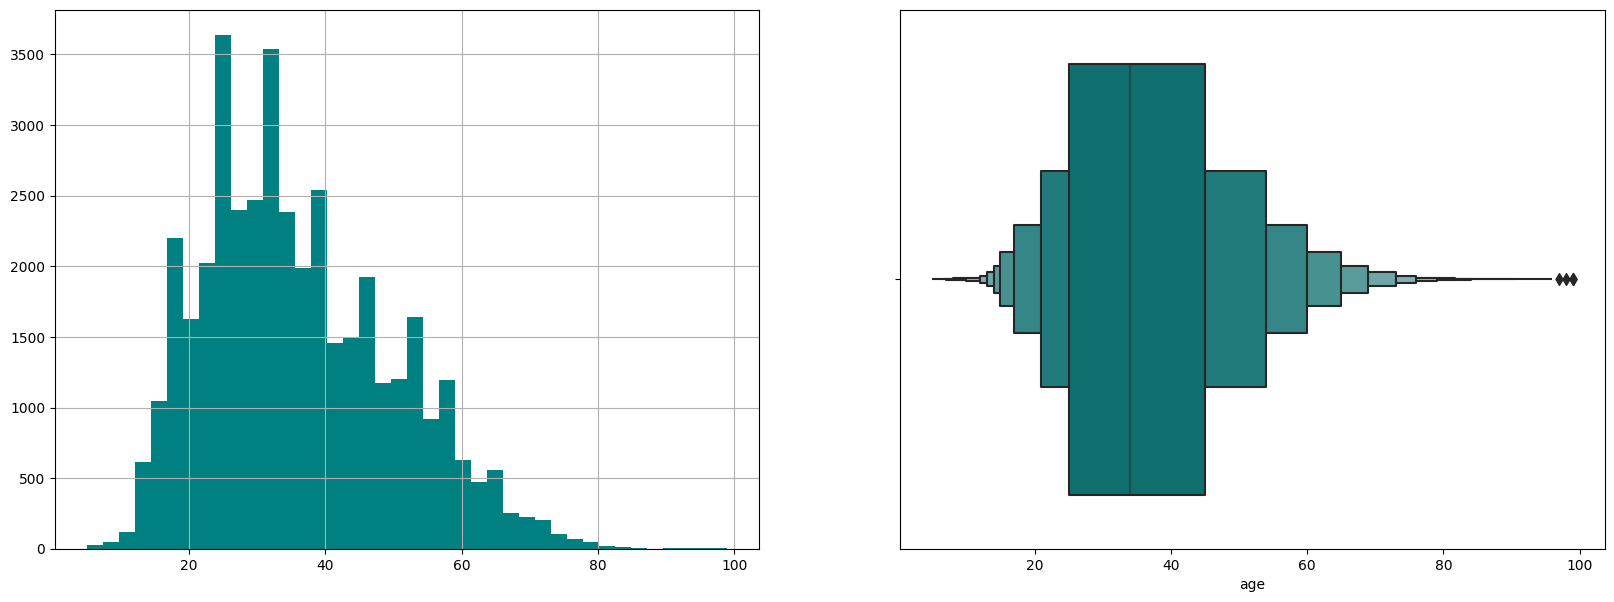

In [53]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [54]:
users['age'].value_counts()

age
29.0    1290
26.0    1250
25.0    1243
34.0    1215
27.0    1207
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: count, Length: 91, dtype: int64

In [55]:
users['age'].nunique()

91

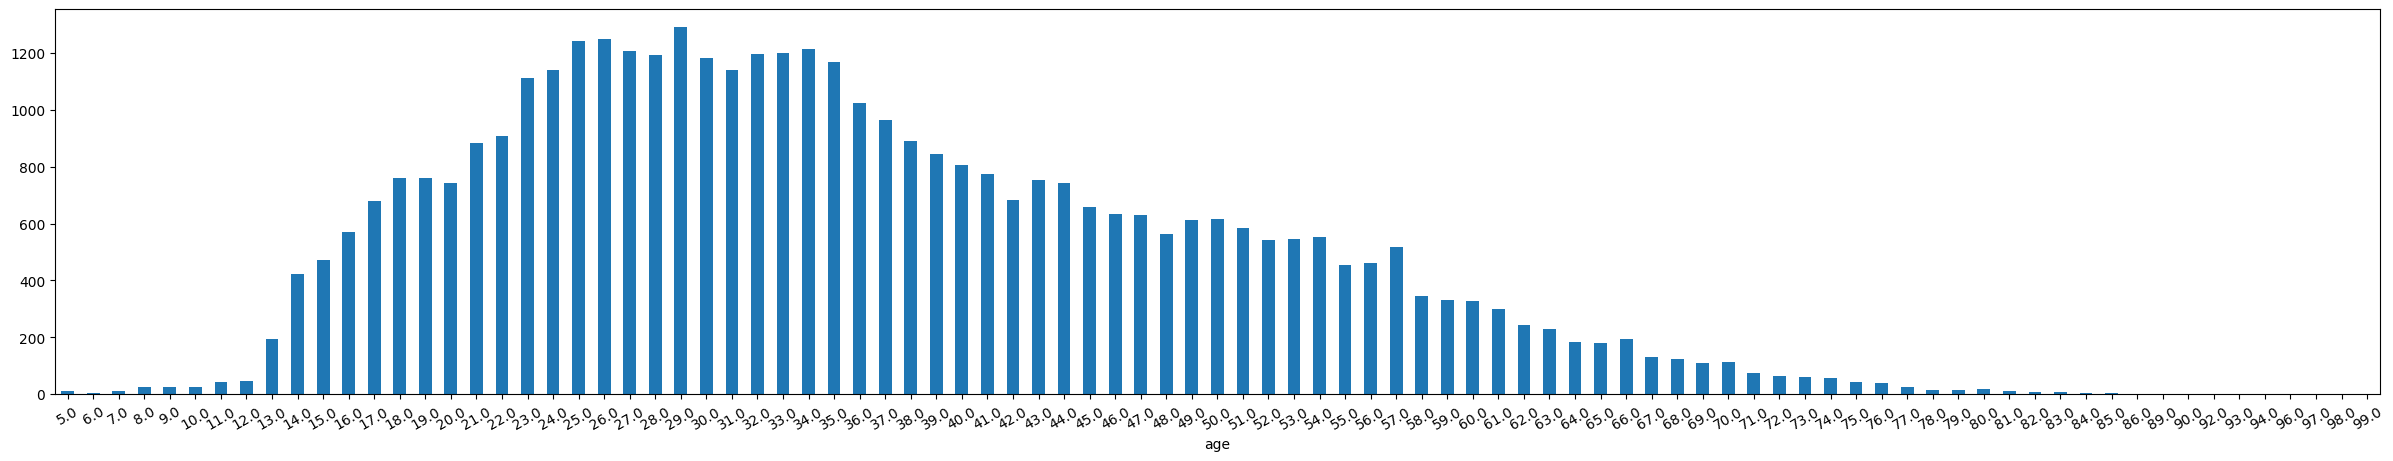

In [56]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

20대 초반 ~ 30대 중반까지의 사용자가 많은 것을 확인할 수 있습니다.

이번에는 사용자들의 거주 국가를 살펴보고 국가별로 사용자의 분포가 다른지 알아보겠습니다.

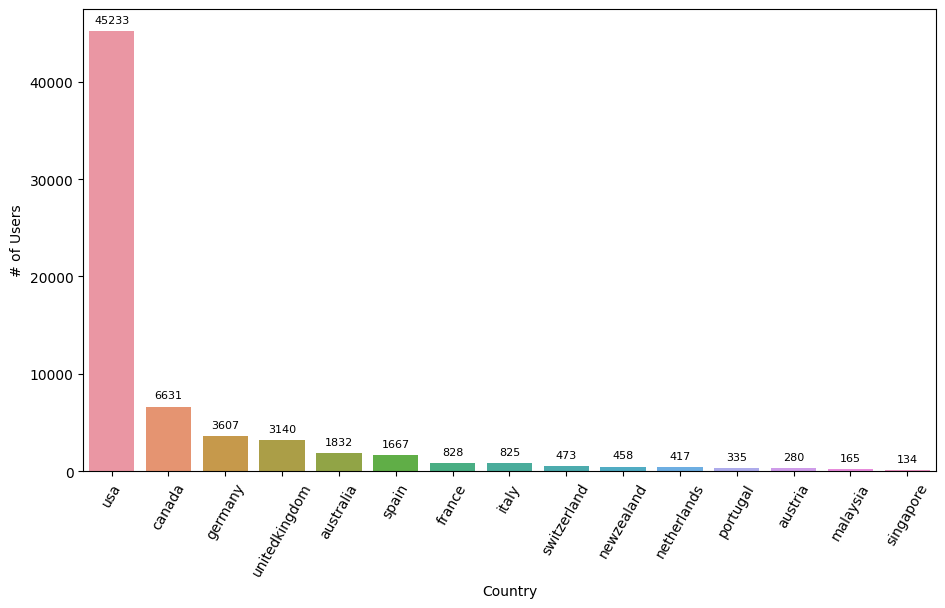

In [57]:
my_dict=(users['location_country'].value_counts()).to_dict() # 국가: 사용자 수
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False) # 내림차순
f = f.head(15) # 상위 15개 국가
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

사용자의 대다수는 미국에 거주중인 것을 확인할 수 있습니다.

국가별 사용자의 나이대를 알아보겠습니다.



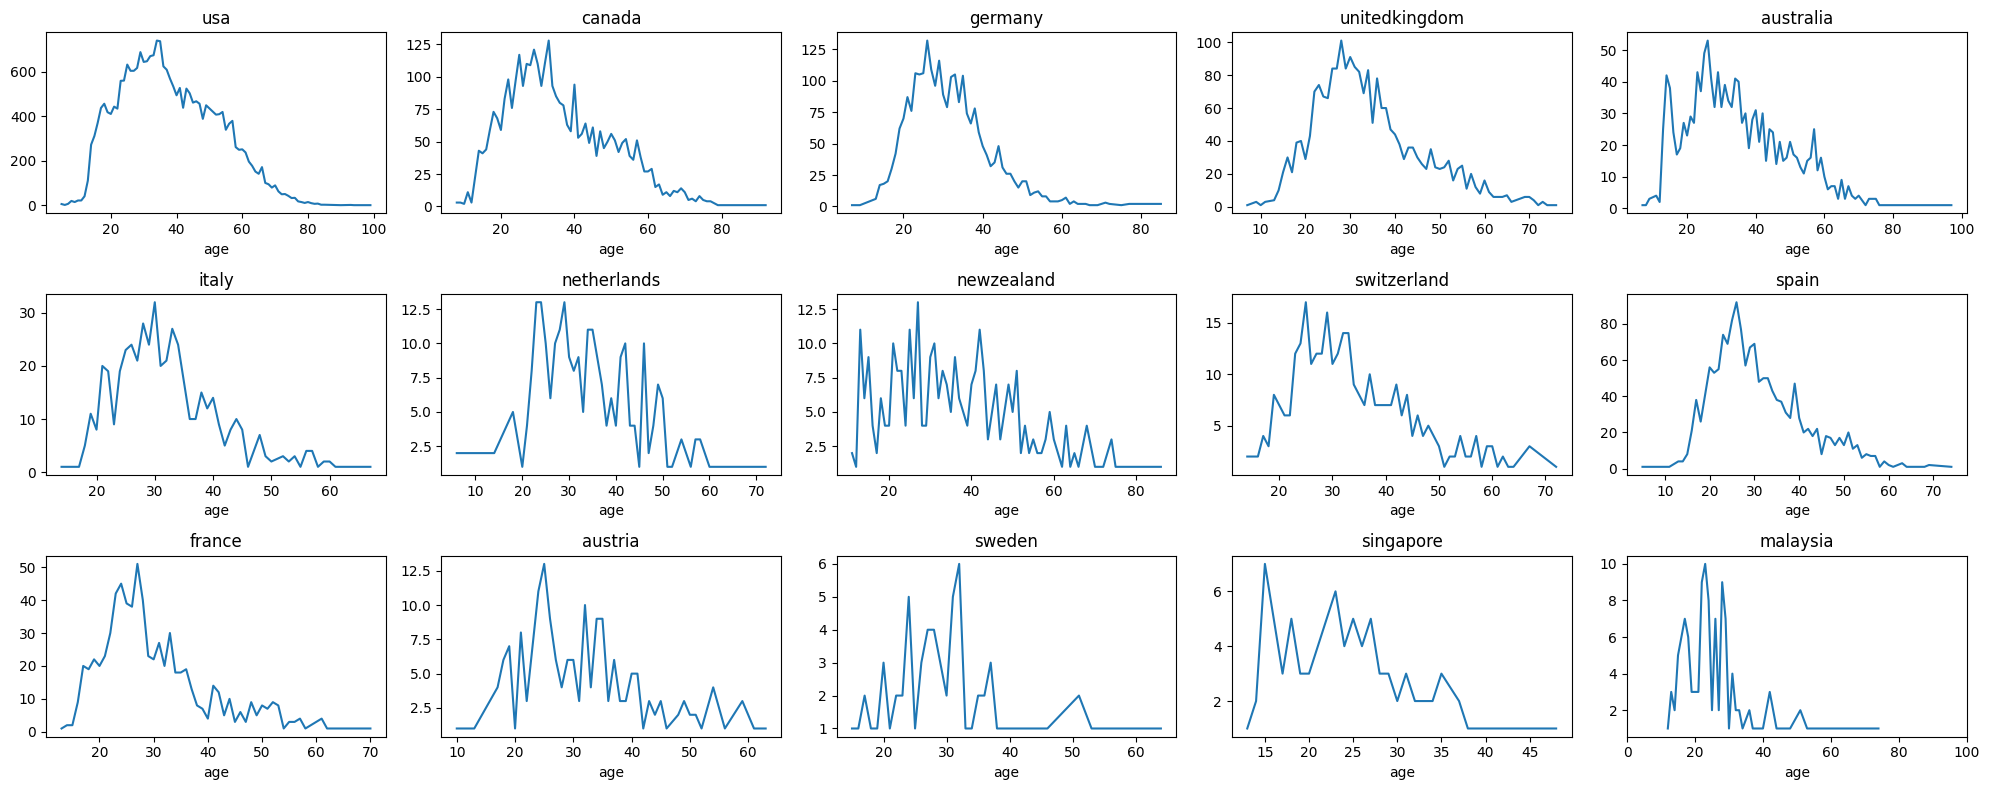

In [70]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

대부분 20~30대 사용자가 많지만, 국가별로 사용자의 분포가 약간씩 차이가 있는 것을 확인할 수 있습니다.
- 뉴질랜드, 네덜랜드의 경우 40대에서도 사용자가 꽤 많음
- 대체로 왼쪽에 치우친 그래프인데 40대나 50대에 갑자기 높은 값을 보이는 경향이 있음
    - 왜 그럴까? (해당 나이대의 특징 파악)
    - 이 연령대의 사람들이 많이 읽은 책은 무엇일까?

age의 결측값을 살펴보겠습니다.

In [59]:
users[users['age'].isna()]['location_country'].value_counts() # age가 결측치인 행의 국가

location_country
usa              20218
canada            3179
germany           1108
unitedkingdom      963
australia          482
                 ...  
latvia               1
auckland             1
burma                1
tunisia              1
macedonia            1
Name: count, Length: 201, dtype: int64

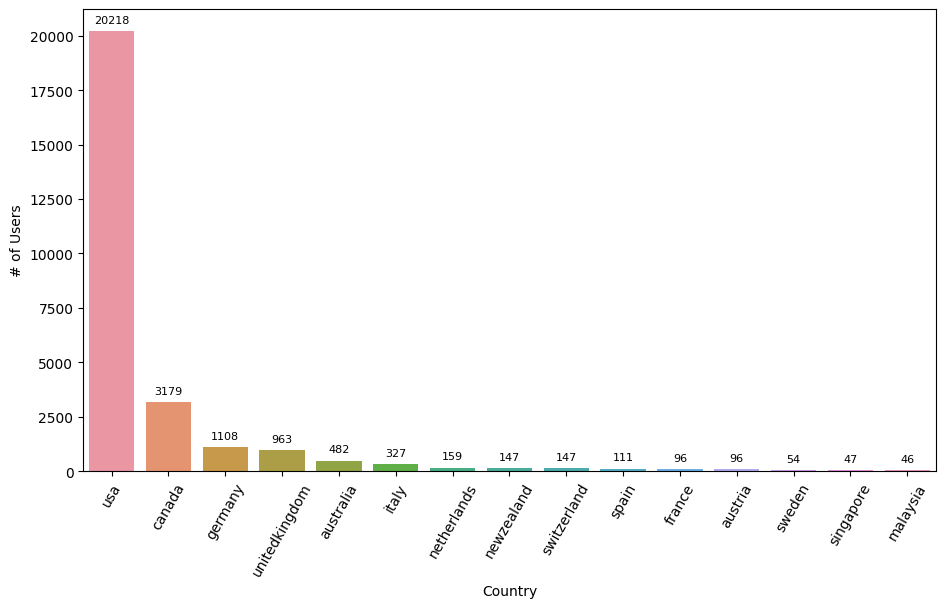

In [60]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

위의 그래프와 큰 차이가 없는 점을 고려했을때, 특정국가에 몰려있다기 보단 골고루 결측치가 퍼져 있다고 판단할 수 있습니다. (미국, 캐나다, 독일, 영국, 호주 순)

국가별 평균, 중앙값, 최빈값 등을 넣어볼수도 있고, 국가별로 큰 나이분포에 큰 차이가 없다고 판단한 경우 전체의 통계치로 채울 수도 있습니다.

또는 결측값을 평균, 중앙값, 최빈값 등의 값으로 채우지 않고 결측값 자체로 가져가는 방법도 있습니다. 

다양한 방법을 시도해보시기 바랍니다.

**어떤 값으로 채우는게 가장 합리적일까?(설득력이 있을까?)**

각 나라의 문화와 교육 체계에 따라 책의 주 독자층이 다를 수 있습니다. -> 그렇다면 특정 책에 대한 해당 국가의 평균 연령대가 가장 나은 선택지일까?

In [655]:
ratings = pd.read_csv(path+'train_ratings.csv')

In [656]:
ratings.head(3)

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8


특정 책의 국가별 평점을 알기위해선 테이블간 merge가 필요함

In [658]:
data = ratings.merge(users, on='user_id', how='left').merge(books, on='isbn', how='left')
# data = data.drop(['summary', 'img_url', 'img_path'], axis = 1)
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 13)


In [659]:
set(ratings['isbn']) - set(books['isbn'])

set()

In [660]:
len(set(ratings['user_id']) - set(users['user_id'])) # 평가를 한 유저의 정보가 없는 경우? 🔥(age, lcation을 알 수가 없음)

0

In [661]:
len(set(users['user_id']) - set(ratings['user_id'])) # user 정보는 있지만 평점은 주지 않은 유저

8289

In [422]:
# 시각화
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index # 책 제목
popular_book = data[data['book_title'].isin(popular_book_list)]

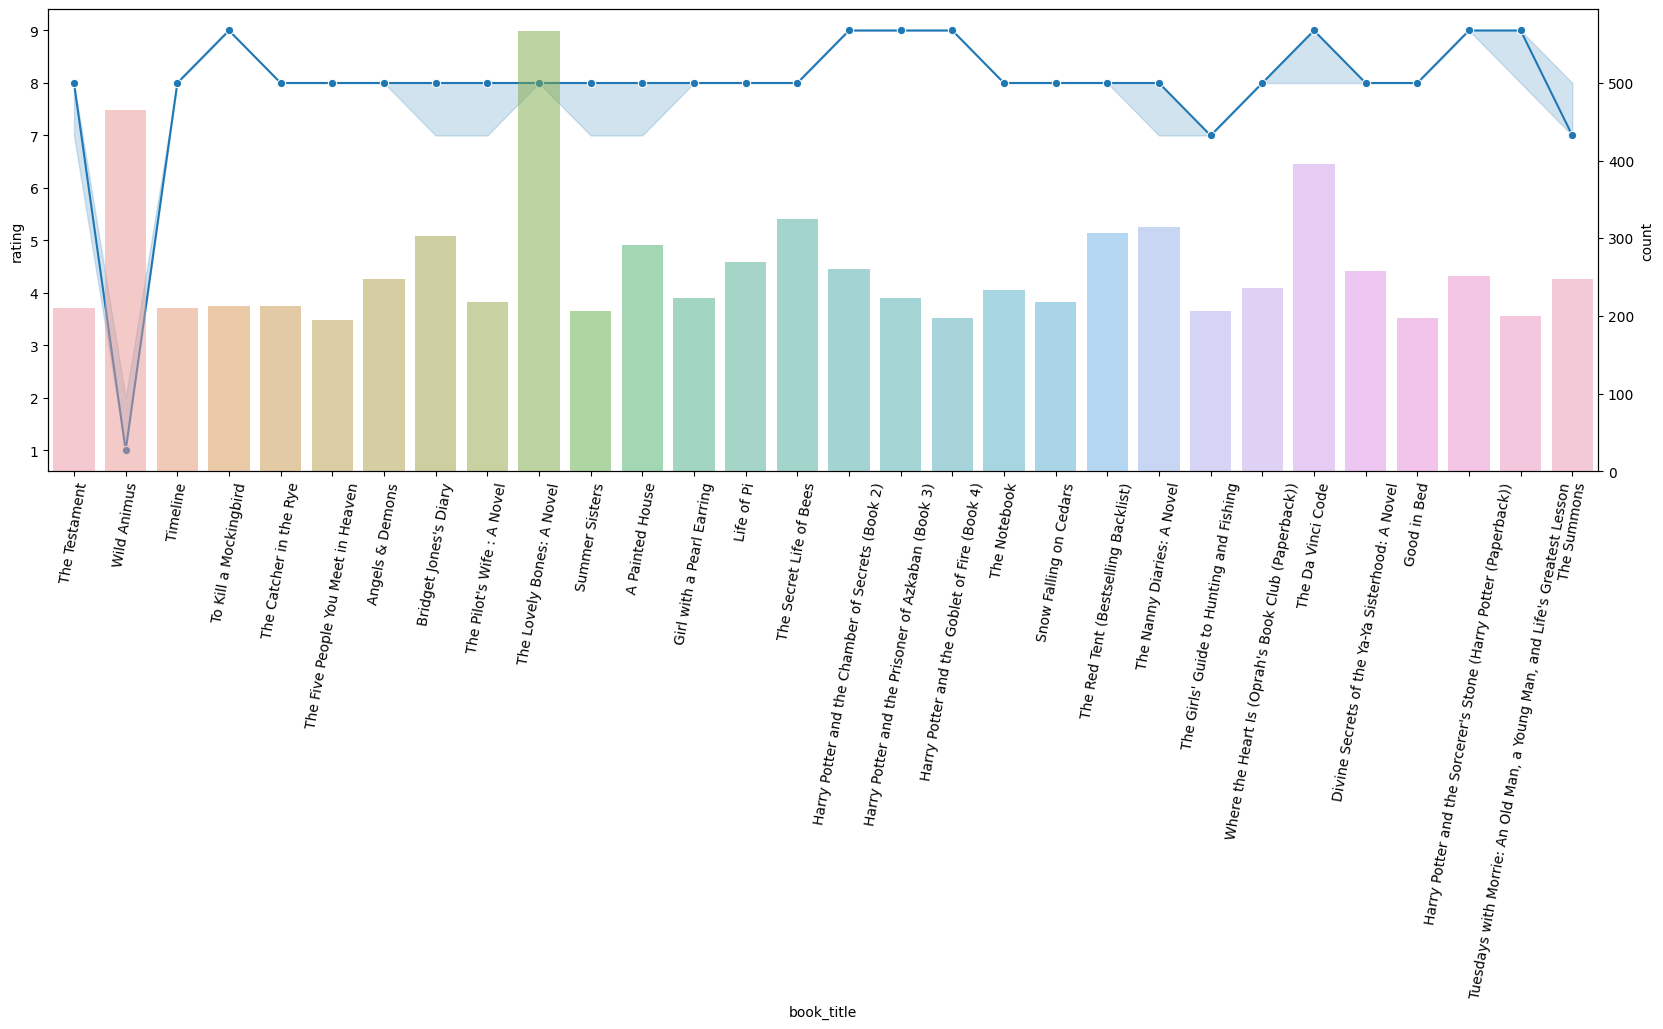

In [423]:
fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data=popular_book, x='book_title', y='rating', marker='o', estimator=np.median, ax=ax1) # 중위수 -> 선 그래프
ax2 = ax1.twinx() # x축 공유

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

대부분의 책이 7~9점대의 평점을 받은 반면, 두 번째로 사람들이 많이 평가한 'Wild Animus'의 rating의 중위수가 1임

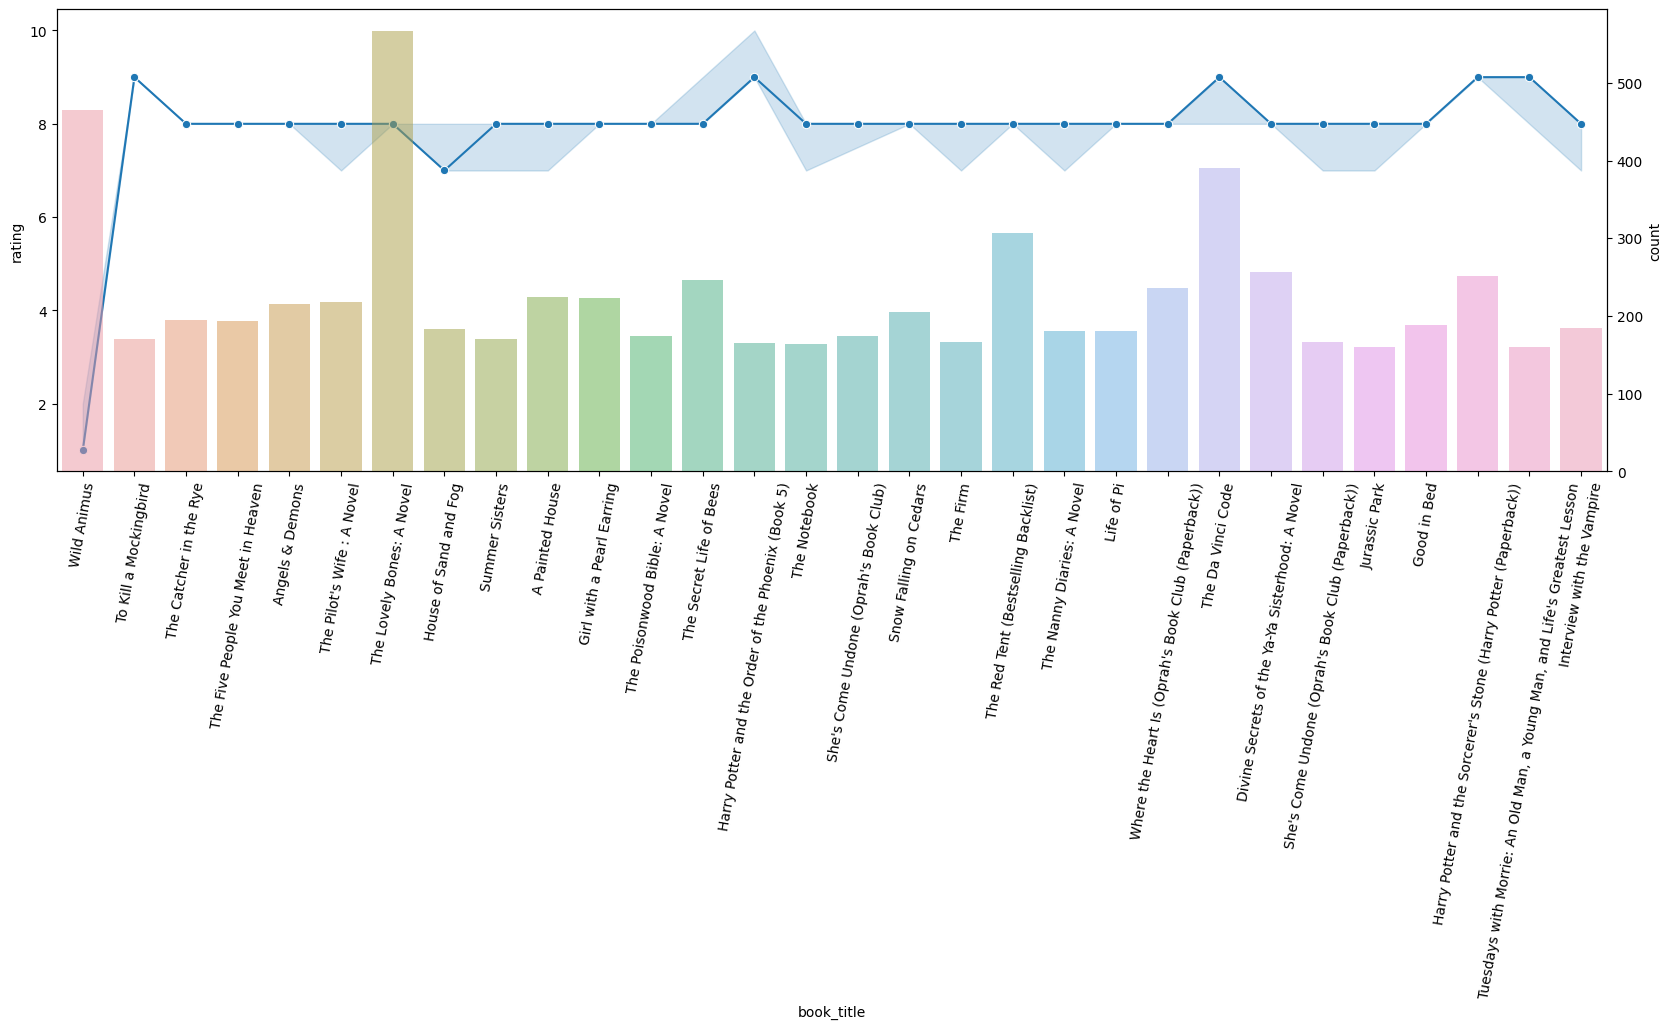

In [424]:
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data=popular_book,x='book_title', y='rating', marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

마찬가지로 대부분의 책이 8~9점대의 평점을 받은 반면, 두 번째로 많이 평가를 받은 책인 'Wild Animus'가 1점대의 낮은 평점을 받음

book_title을 사용했을때와 isbn을 사용한 결과에 차이가 있는 것을 볼 수 있습니다.

이는 isbn이 책 고유번호로써 특정 국가에서 인기 차이가 반영되기 때문이라고 생각할 수 있습니다. 

~~또한 가장 많이 읽힌 책이 오히려 median 및 평균이 낮은 것을 확인 할 수 있는데 이는 rating 1이 많아서 그런것일수도 있으므로 이를 제외해 보겠습니다.~~

In [425]:
# Wild Animus의 평점 분포 확인

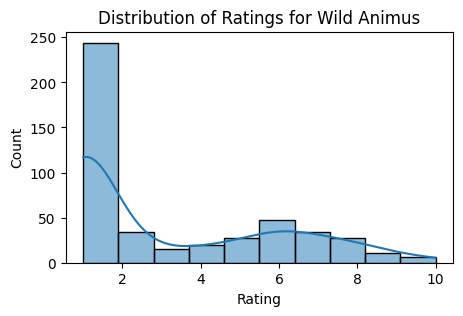

In [426]:
wild_animus = data[data['book_title'] == 'Wild Animus']

plt.figure(figsize=(5,3))
sns.histplot(data=wild_animus, x='rating', bins=10, kde=True)
plt.title('Distribution of Ratings for Wild Animus')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [427]:
wild_animus['rating'].value_counts()

rating
1     244
6      47
2      34
7      34
5      27
8      27
4      20
3      15
9      11
10      6
Name: count, dtype: int64

Wild Animus의 평점은 대부분 1점을 받았음 -> age를 채울 때 이상치가 있을 수 있으니 중위수를 사용하는게 타당해보임

In [428]:
# age의 결측치를 해당 책에 대해 평가를 내린 국가의 중위수로 채우는게 가능한가? 여러 책에 대해 평가했는데 그 중위수가 다 다르다면?

In [864]:
data.shape

(306795, 13)

In [663]:
# 사용자별 책을 많이 읽은순으로 내림차순 정렬
data.groupby('user_id')['rating'].count().sort_values(ascending=False)[:5]

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
Name: rating, dtype: int64

In [665]:
# 단순히 특정 책 한권의 독자층 연령대로 채우는 것보다 유저가 읽은 책의 모든 독자층을 조사해보는 것이 합리적일 것 같다는 가정 🔥🔥🔥
# read_list에 포함된 책들의 중앙값 계산
medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).median()

# 중앙값이 있는 책들에 대해 연령대 분포 계산
age = np.floor(medians / 10) * 10
age[age >= 60] = 60
age[age < 20] = 10

res_age = age.value_counts().idxmax()
print(res_age) # 최종적으로 추측한 연령

30.0


In [411]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age(u_id):
    read_list = data[data['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).median() # read_list에 포함된 책들 각각의 중앙값 계산
    
    # 중앙값이 있는 책들(age가 있어야됨)
    age = np.floor(medians / 10) * 10
    age[age >= 60] = 60 # 60대 이상은 모두 60대로
    age[age < 20] = 10 # 10대 이하는 모두 10으로
    age_dict = age.value_counts().reindex(range(10, 70, 10), fill_value=0).to_dict() # value_counts 과정에서 nan값 무시
    
    if max(age_dict.values()) != 0: # 해당 책에 대해 평점을 준 사람의 나이가 하나라도 있는 경우
        res_age = max(age_dict, key=age_dict.get) # age_dict의 키 중에서 값이 가장 큰 키를 반환. 만약 모든 value값이 같다면 가장 앞에 있는 key값 반환(10)
    # 해당 책에 대해 평가한 사람의 나이가 없는 경우
    else:
        res_age = np.nan
    return res_age

In [666]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_mean(u_id):
    read_list = data[data['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).mean() # read_list에 포함된 책들 각각의 중앙값 계산
    
    # 중앙값이 있는 책들(age가 있어야됨)
    age = np.floor(medians / 10) * 10
    age[age >= 60] = 60 # 60대 이상은 모두 60대로
    age[age < 20] = 10 # 10대 이하는 모두 10으로
    
    res_age = age.mean() # 모든 값이 nan이면 nan값 반환
    return 60 if res_age >= 60 else (10 if res_age < 20 else np.floor(res_age/10)*10)

In [667]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_median(u_id):
    read_list = data[data['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).median() # read_list에 포함된 책들 각각의 중앙값 계산
    
    # 중앙값이 있는 책들(age가 있어야됨)
    age = np.floor(medians / 10) * 10
    age[age >= 60] = 60 # 60대 이상은 모두 60대로
    age[age < 20] = 10 # 10대 이하는 모두 10으로
    
    res_age = age.mean() # 모든 값이 nan이면 nan값 반환
    return 60 if res_age >= 60 else (10 if res_age < 20 else np.floor(res_age/10)*10)

In [677]:
train_ratings = pd.read_csv('./data/train_ratings.csv')

train_ratings = train_ratings.merge(users, on = 'user_id')


In [ ]:
gia = train_ratings.groupby('isbn'

In [ ]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_mean(u_id):
    read_list = data[data['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).mean() # read_list에 포함된 책들 각각의 중앙값 계산
    
    # 중앙값이 있는 책들(age가 있어야됨)
    # age = np.floor(medians / 10) * 10
    age = 
    # age[age >= 60] = 60 # 60대 이상은 모두 60대로
    # age[age < 20] = 10 # 10대 이하는 모두 10으로
    
    res_age = age.mean() # 모든 값이 nan이면 nan값 반환
    return 60 if res_age >= 60 else (10 if res_age < 20 else np.floor(res_age/10)*10)

In [695]:
# 독서왕 11676씨의 도서 목록 -> 5520개의 책을 읽으셨습니다!! 대단하시네요!
read_list = data[data['user_id'] == 11676]['isbn']

In [697]:
# 단순히 특정 책 한권의 독자층 연령대로 채우는 것보다 유저가 읽은 책의 모든 독자층을 조사해보는 것이 합리적일 것 같다는 가정 🔥🔥🔥
# read_list에 포함된 책들의 중앙값 계산
means = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).mean()

In [704]:
# 중앙값이 있는 책들에 대해 연령대 분포 계산
age = np.floor(np.mean(means) / 10) * 10
if age < 20:
    age = 10
elif age >= 60:
    age = 60

print(age) # 최종적으로 추측한 연령

30.0


In [885]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_mean(u_id:int, df):
    read_list = df[df['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    means = df.loc[df['isbn'].isin(read_list), 'age'].groupby(df['isbn']).mean() # read_list에 포함된 책들 각각의 중앙값 계산
    
    age = np.floor(np.mean(means)) 
    # binning(20대 미만은 10대, 60대 이상은 60대로 mapping)
    if age < 20:
        age = 10
    elif age >= 60:
        age = 60
    return age

In [893]:
data[data['age'].isna()]['user_id']

0              8
2         123629
3         200273
4         210926
12        208059
           ...  
306782    278633
306783    278633
306784    278636
306785    278637
306786    278648
Name: user_id, Length: 92662, dtype: int64

In [712]:
check_age.drop('predict_age_sumin', axis=1, inplace=True)

In [713]:
check_age.head(3) # 특정 유저의 실제 나이

,user_id,age
0,19,14.0
1,42,17.0
2,44,51.0


In [720]:
check_age.loc[:, 'predict_age_sumin'] = check_age['user_id'].map(predict_age_using_mean)

In [872]:
check_age

,user_id,age,predict_age_sumin,giagua
0,19,14.0,35.0,35.0
1,42,17.0,34.0,34.0
2,44,51.0,41.0,41.0
3,56,24.0,31.0,31.0
4,56,24.0,31.0,31.0
...,...,...,...,...
16702,24018,61.0,61.0,61.0
16703,24020,26.0,26.0,26.0
16704,24044,65.0,47.0,47.0
16705,24044,65.0,47.0,47.0


In [727]:
temp = train_ratings.merge(users, on = 'user_id')
gia = train_ratings.groupby('isbn')['age'].mean() # 특정 책의 독자 평균 나이
temp['gia'] = temp['isbn'].map(gia)
grouped_isbn_age_grouped_uid_gia = temp.groupby('user_id')['gia'].mean() # 
temp['giagua'] = temp['user_id'].map(grouped_isbn_age_grouped_uid_gia)

In [732]:
temp = temp[['user_id', 'giagua']]

In [734]:
check_age = check_age.merge(temp, on='user_id')

In [737]:
check_age['giagua'] = check_age['giagua'].apply(lambda x:np.floor(x))

In [ ]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_sh(u_id):
    temp = train_ratings.merge(users, on = 'user_id')
    gia = train_ratings.groupby('isbn')['age'].mean() # 특정 책의 독자 평균 나이
    temp['gia'] = temp['isbn'].map(gia)
    grouped_isbn_age_grouped_uid_gia = temp.groupby('user_id')['gia'].mean() # 
    temp['giagua'] = temp['user_id'].map(grouped_isbn_age_grouped_uid_gia)
    
    return age

In [ ]:
gia = train_ratings.groupby(‘isbn’)[‘age’].mean() # 특정 책의 독자 평균 나이
temp[‘gia’] = temp[‘isbn’].map(gia)
grouped_isbn_age_grouped_uid_gia = temp.groupby(‘user_id’)[‘gia’].mean() # 
temp[‘giagua’] = temp[‘user_id’].map(grouped_isbn_age_grouped_uid_gia)
temp[‘giagua’].isna().mean()

In [ ]:
temp = df_train_ratings.merge(df_users, on = ‘user_id’)
gia = temp.groupby(‘isbn’)[‘age’].mean() # 특정 책의 독자 평균 나이
temp[‘gia’] = temp[‘isbn’].map(gia)
grouped_isbn_age_grouped_uid_gia = temp.groupby(‘user_id’)[‘gia’].mean() # 
temp[‘giagua’] = temp[‘user_id’].map(grouped_isbn_age_grouped_uid_gia)
temp[‘giagua’].isna().mean()

In [ ]:
feature2index = dict(zip(temp.columns, range(len(temp.columns))))
temp[‘final’] = temp.apply(lambda x : x[feature2index[‘giagua’]] if type(x[feature2index[‘age’]]) == float and np.isnan(x[feature2index[‘age’]]) else x[feature2index[‘age’]], axis = 1)
uid2age = dict(zip(temp[‘user_id’].values, temp[‘final’].values))

In [ ]:
def binning_age(x):
    if np.isnan(x):
        return np.nan
    elif age < 20:
        age = 10
    elif age >= 60:
        age = 60
    return age

In [ ]:
df_users[‘age’] = df_users[‘user_id’].map(uid2age)
df_users[‘binning_age’] = df_users[‘age’].apply(binning_age)

In [412]:
# 특정 유저가 읽은 책들의 연령대를 비교해서 해당 유저의 연령대를 예측, 반환하는 함수
def predict_age_using_mean(u_id):
    read_list = data[data['user_id'] == u_id]['isbn'] # 해당 유저가 읽은 모든 책 목록
    medians = data.loc[data['isbn'].isin(read_list), 'age'].groupby(data['isbn']).median() # read_list에 포함된 책들 각각의 중앙값 계산
    
    # 중앙값이 있는 책들(age가 있어야됨)
    age = np.floor(medians / 10) * 10
    age[age >= 60] = 60 # 60대 이상은 모두 60대로
    age[age < 20] = 10 # 10대 이하는 모두 10으로
    
    res_age = age.mean() # 모든 값이 nan이면 nan값 반환
    return 60 if res_age >= 60 else (10 if res_age < 20 else np.floor(res_age/10)*10)

In [684]:
# 실제 나이값이 있는 유저 데이터를 활용해 예측값과 실제값의 차이가 어떻게 나오는지 확인(RMSE)
check_age = data[data['age'].notnull()].groupby('user_id')['age'].mean().reset_index()
# check_age['age'] = check_age['age'].apply(lambda x:np.floor(x/10)*10)

# lambda 함수를 사용하여 60 이상은 60으로, 20 이하는 10으로 바꾸기
# check_age['age'] = check_age['age'].apply(lambda x: 60 if x >= 60 else (10 if x < 20 else x))

check_age = check_age[:3000] # 데이터 너무 많으니까 3000개만 확인

In [674]:
check_age.loc[:, 'predict_age_median'] = check_age['user_id'].map(predict_age_using_median)
check_age.loc[:, 'predict_age_mean'] = check_age['user_id'].map(predict_age_using_mean)

In [675]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(check_age['age'], check_age['predict_age_median']))
print("중위수를 사용했을 때 RMSE:", rmse)

rmse = math.sqrt(mean_squared_error(check_age['age'], check_age['predict_age_mean']))
print("평균을 사용했을 때 RMSE:", rmse)

중위수를 사용했을 때 RMSE: 9.366607354497857
평균을 사용했을 때 RMSE: 9.166969691961096


엄청 큰 차이는 아니지만 평균을 사용했을 때의 성능이 더 좋았음

본격적으로 age의 null값을 채워보자

In [430]:
null_age_users = data[data['age'].isna()]['user_id'].unique() # age가 null값인 user의 age를 채워보자
print(len(null_age_users))

24085


In [431]:
# data.loc[data['user_id'].isin(null_age_users), ['user_id', 'isbn']].groupby('user_id')['isbn']

In [432]:
age_dict = {}
for u_id in tqdm(null_age_users):
    age_dict[u_id] = predict_age_using_mean(u_id)

data.loc[data['user_id'].isin(null_age_users), 'age'] = data.loc[data['user_id'].isin(null_age_users), 'user_id'].map(age_dict)

100%|██████████| 24085/24085 [05:09<00:00, 77.81it/s]


In [402]:
# 평균을 사용한 후 결측치 개수
data['age'].isnull().sum()

5540

In [448]:
data['user_id'].value_counts()

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
          ... 
54908        1
236844       1
44531        1
93836        1
278713       1
Name: count, Length: 59803, dtype: int64

In [499]:
# null_age_users = set(data[data['age'].isna()]['user_id'])
# for u_id in tqdm(null_age_users):
#     country = data[data['user_id'] == u_id]['location_country'].values[0] # 해당 유저가 살고 있는 나라(state로 바꿔볼 수도 있을듯. 우선 과적합 방지를 위해 국가로 시도)
#     age = data[data['location_country'] == country]['age'].mean()    
#     idx = data[data['user_id'] == u_id].index
#     data.loc[idx, 'age'] = age

data['age'] = data.groupby('location_country')['age'].transform(lambda x: x.fillna(x.mean()))

In [502]:
data['age'].isnull().sum() # 국가로 처리한 이후에 남은 결측값은 전체 평균으로 fill

10

In [504]:
data.loc[data[data['age'].isna()].index, 'age'] = data['age'].mean()

In [505]:
data['age'].isnull().sum()

0

In [506]:
data.isnull().sum()

user_id                     0
isbn                        0
rating                      0
age                         0
location_city               0
location_state              0
location_country            0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   0
language               119084
category               121221
dtype: int64

---

# Books

## 1) Exploratory Data Analysis

In [513]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [517]:
books.head(3)

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg


In [519]:
books.isnull().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [612]:
books['language'].unique()

array(['en', nan, 'de', 'fr', 'es', 'ca', 'it', 'da', 'nl', 'pt', 'ro',
       'no', 'ms', 'la', 'ru', 'el', 'zh-CN', 'th', 'gl', 'ja', 'fa',
       'eo', 'gd', 'ga', 'vi', 'zh-TW', 'ko'], dtype=object)

In [519]:
books = books.drop(['summary', 'img_url', 'img_path'], axis=1)

**language, category, summary에 결측치가 많음** -> summary는 안 쓸 예정

1. isbn이 정확히 어떻게 구성됐는지도 다시한번 살펴봐야 함.
2. book_author의 결측치 처리
3. year_of_publication으로 책의 출간연도 살펴보기
4. publisher가 가장 많은 국가
5. language 내림차순으로 살펴보기
6. category 데이터 어떻게 처리할지🔥

### 1-1) isbn

`isbn이 어떻게 구성됐는지 살펴보자.`

isbn은 책의 개별적인 고유번호를 나타내는 10자리 숫자입니다.

출판 국가, 출판사 번호, 항목 번호, 확인 숫자 순서로 구성되며 확인 숫자의 경우 10을 나타내는 X가 오기도 합니다.

이 번호를 활용하여 출판사의 항목 갯수를 줄여보도록 하겠습니다.

https://isbn-information.com/the-10-digit-isbn.html    
https://www.wikihow.com/Understand-an-ISBN-Code   
https://www.thebookdesigner.com/self-publishing-basics-isbn/   
https://en.wikipedia.org/wiki/ISBN    

- Group identifier
- Publisher identifier
- Title identifier
- Check digit

In [865]:
books['publisher'].nunique() # cardinality가 높음

11571

In [598]:
num = set()
name = []
for isbn in set(books[books['publisher'] == 'Harlequin']['isbn']):
    if isbn[:4] not in num:
        num.add(isbn[0:4])
        print(isbn)
print(num)

0373292953
1551664658
0671572806
{'0671', '0373', '1551'}


In [567]:
books[books['isbn'] == '1551664658']

,isbn,book_title,book_author,year_of_publication,publisher,language,category
124277,1551664658,Confession,Elizabeth Gage,1998.0,Harlequin,en,['Fiction']


In [568]:
books[books['isbn'] == '0671572806']

,isbn,book_title,book_author,year_of_publication,publisher,language,category
138765,0671572806,Sullivan's Woman,Nora Roberts,1984.0,Harlequin,NaN,NaN


In [ ]:
num = {}
for isbn in set(books[books['publisher']=="Penguin Books"]['isbn']):
    if isbn[:3] not in num: # 4자리로 확인했을 때 더 많이 분류되지만, 실제로 확인해보면 014x와 014y는 둘다 penguin books였음
        num[isbn[:3]] = 1
        print(isbn)
    else:
        num[isbn[:3]] += 1
print(num)

0140140360
0451192222
1854712209
0670869406
1898141207
1594200173
0802713661
{'014': 1922, '045': 8, '185': 1, '067': 9, '189': 1, '159': 1, '080': 1}


In [ ]:
books[books['isbn'] == '0451192222']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
16263,0451192222,Witness for the Defense,Michael C. Eberhardt,1998.0,Penguin Books,http://images.amazon.com/images/P/0451192222.0...,en,['Fiction'],His lifelong career in jeopardy after being ac...,images/0451192222.01.THUMBZZZ.jpg


- https://isbn-information.com/the-10-digit-isbn.html      
위의 페이지를 통해 알 수 있듯이 isbn의 publisher identifier는 7자리 숫자까지 가능하다.(This may consist of up to seven digits.)      
일반적으로 책에는 -로 구분돼서 각 identifier가 어디까지인지 구분이 되지만 우리는 -가 없는 연결된 숫자이기 때문에 명확하게 identifier의 길이를 구분할 수 없음.     
(대략적으로 추측만 가능함)     

- https://en.wikipedia.org/wiki/List_of_ISBN_registration_groups      
group identifier(국가) 코드 역시 지우님이 말했던 것처럼 5자리 코드까지 가능해서 이 코드를 통해 국가코드는 확인할 수 있을 듯    

통상적으로 group identifier가 정해진 후, publisher identifier의 코드가 정해지는데 큰 회사일수록 publisher identifier의 길이가 짧다고함.    
(이유는 뒤에오는 title identifier 때문인데, 큰 출판사일수록 출간하는 책이 많고 title identifier 역시 길어질수밖에 없기 때문. 자동차번호로 생각하면 이해하기 쉬울듯)    

위의 코드로 출판사가 Penguin Books인 행의 isbn을 앞에서부터 3자리 기준으로 count 했을 때 출판사는 분명 🐧이지만,    
- 0451192222: Onyx(https://www.amazon.com/Witness-Defense-Michael-C-Eberhardt/dp/0451192222)  다른회사   
- 1854712209: https://www.amazon.com/Treasure-Island-Robert-Louis-Stevenson/dp/1854712209 애초에 group identifier가 다름. 같은 출판사가 각 그룹마다 다른 출판사 식별자를 가질 수 있음 
- 0670869406: Viking Adult(https://www.amazon.com/Revenge-Cootie-Girls-Hudson-Mystery/dp/0670869406)  다른회사  
- 1898141207: Penguin Group USA(https://www.amazon.com/Queen-These-Are-Days-Lives/dp/1898141207) 계열사.   
- 1594200173: Penguin Press HC, The(https://www.amazon.com/Gag-Rule-Suppression-Stifling-Democracy/dp/1594200173) 계열사임   
- 0802713661: Walker Books(https://www.amazon.in/Brunelleschis-Dome-Renaissance-Reinvented-Architecture/dp/0802713661)    
직접 해당 isbn의 책을 검색해보면 다른 출판사가 나온다

-> 결론 noise가 개많다.

In [618]:
# isbn의 앞에서부터 3자리까지를 slicing해서

In [651]:
books[books['isbn'].str.startswith('185471')]['publisher'].unique()

array(['Penguin Books Ltd', 'Penguin Books', 'Godfrey Cave / Claremont',
       'Dutton Books', 'Bloomsbury Books'], dtype=object)